# 02. Machine Learning for music playlists: Data Visualisation

This is the second post in a series of posts devoted to building music playlists with Scikit-Learn tools.   
This notebook covers visualisation of data I prepared in the previous post [01_Data_preparation](https://github.com/Tykovka/itunes-music-analysis/blob/master/01_Data_preparation.ipynb). 

In the previous step, I parsed iTunes music library XML file to create pandas DataFrame (DF) to use as a test dataset. I also transformed the CSV file with labelled tracks to a DF to use as a training dataset. Using the Echo Nest API I got 11 music attributes for every song in both sets.

As a result of the above manipulations I have two datasets: 
* training set contains 143 tracks labelled with one of the three classes: "ballet", "cycling", "yoga";
* test dataset contains 536 non-labelled tracks. 

Previous posts cover the following steps:
* [00_Overview](https://github.com/Tykovka/itunes-music-analysis/blob/master/00_Overview.ipynb) — Overview of the analysis, its goals and methods, installation notes.  
* [01_Data_preparation](https://github.com/Tykovka/itunes-music-analysis/blob/master/01_Data_preparation.ipynb) — Data gathering and cleaning.

The next step in my analysis is to visualize both datasets and examine track attributes. 

#### Contents of the notebook
* [Data overview](#Data-overview)
    * [Training data overview](#Training-data-overview)
    * [Training data visualisation](#Training-data-visualisation)
    * [Test data overview](#Test-data-overview)
    * [Test data visualisation](#Test-data-visualisation)
* [Summary](#Summary)

I use **[Matplotlib](http://matplotlib.org/)** and **[Seaborn](https://stanford.edu/~mwaskom/software/seaborn/)** packages in this notebook for data visualization. 

I start with importing modules required in the following notebook. 

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
import numpy as np

# set seaborn plot defaults
import seaborn as sns; 
sns.set(palette="husl")

# format floating point numbers
# within pandas data structures
pd.set_option('float_format', '{:.2f}'.format)

I store both datasets in HDF5 file format as pandas dataframes.

In [2]:
store = pd.HDFStore('music_data.h5')

# load train data as DF
train_df = store['train_df']

# load test data as DF
test_df = store['test_df']

## Data overview  
  
I have two DataFrames with track attributes data from the Echo Nest API. Next step is to take a look at what I'm working with.
### Training data overview

In [3]:
# list of categories
categories = list(pd.unique(train_df.category.ravel()))

print ("Tracks in the dataset belong " 
       "to {} classes: {}."
       .format(len(categories), ", ".join(categories)))

# count tracks in each category
cat_count = pd.value_counts(train_df.category.ravel())

# print categories
for category in categories:
    print ("{} tracks represent \'{}\' class."
           .format(cat_count[category], category))

Tracks in the dataset belong to 3 classes: ballet, cycling, yoga.
49 tracks represent 'ballet' class.
45 tracks represent 'cycling' class.
49 tracks represent 'yoga' class.


All classes are represented almost equally.

In [5]:
# sample of data
train_df.sample(3)

,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence,song,artist,category
72,0.55,0.64,0.19,0.84,6,-19.37,1,0.04,120.00,4,0.07,they move on tracks of never-ending light,this will destroy you,yoga
146,0.00,0.51,0.90,0.00,2,-3.74,0,0.03,136.00,4,0.55,Part of me,Music Go Music,cycling
79,0.96,0.55,0.17,0.93,3,-16.83,0,0.03,100.00,4,0.04,Bless This Morning Year,Helios,yoga


In this notebook I'm going to examine numeric track features by plotting them. It's important to point out that features "key", "mode", and "time_signature" are discrete, not continuous as other features, with a limited number of values.

In [6]:
for f in ["key", "mode", "time_signature"]:
    u_val = sorted(pd.unique(train_df[f]))
    print ("{!r} takes {} values: {}."
           .format(f, len(u_val), u_val))

'key' takes 12 values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11].
'mode' takes 2 values: [0, 1].
'time_signature' takes 4 values: [1, 3, 4, 5].


These features will be plotted separately. 

### Training data visualisation
#### — Scatterplot —
I plot continuous numeric attributes with pairplot function to examine pairwise relationships in a dataset. Pairplots are a simple representation using a set of 2D scatterplots, plotting each component against another component.

The diagonal axes show the univariate distribution of the data for the variable in that column. Each track class is coloured according to their classification with a different colour so I can see the behaviour of classes. 

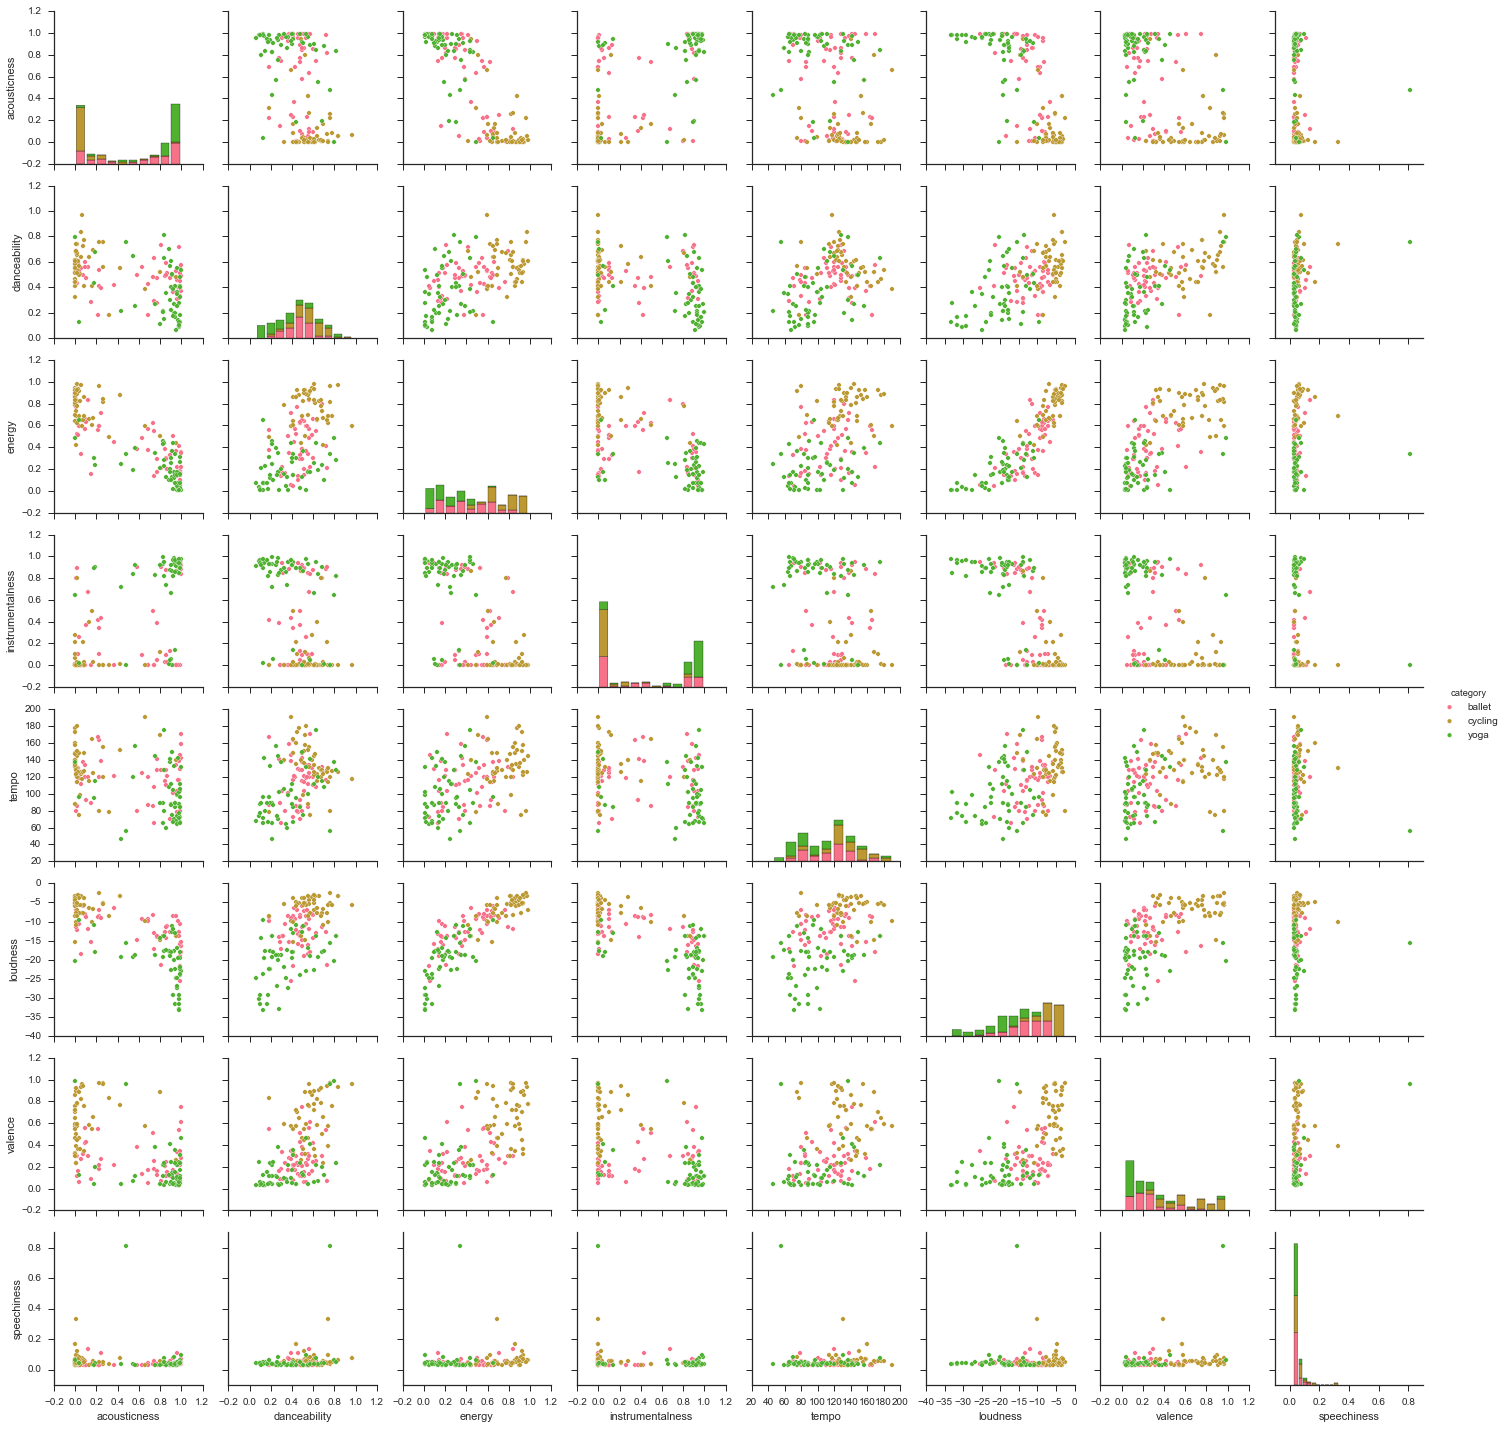

In [7]:
sns.set_style("ticks")
sns.pairplot(train_df, hue="category", 
             vars=['acousticness', 'danceability', 
                   'energy', 'instrumentalness', 
                   'tempo', 'loudness','valence',
                  'speechiness'])

Looking at the plot I can make the following observations about the data:
* Datapoints of the cycling and yoga classes tend to form clusters, whereas observations of the ballet class are very spread out.
* Points of the ballet class on many plots lie in-between the other two classes (e.g. "loudness-energy", "valence-loudness" plots), filling the space between the yoga and cycling classes.   
* The "speechiness" level is the same in all three classes with several outliers. 
* Acousticness and instrumentalness attributes have sort of a gap in the middle; tracks in the training set have either very low or very high level of acousticness and instrumentalness.
* Energy seems to be correlated with loudness. The higher the loudness of the track, the higher its level of energy.

#### — Count plot —
Attributes "key", "mode", and "time_signature" are discrete, not continuous, with a limited number of values, or categorical bins. Each track falls into one of these categorical bins. To visualize these bins I create a count plot. Count plot shows the counts of observations in each categorical bin using bars.   

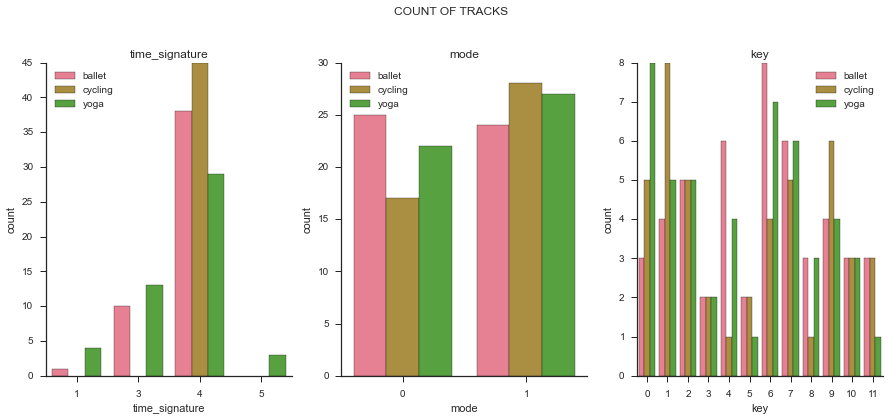

In [8]:
# create 3 subplots
fig0, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3,
                                      sharey=False,
                                      figsize=(15,6))

# space between the title and the plot
plt.subplots_adjust(top=0.85) 
# add a title
fig0.suptitle('COUNT OF TRACKS')

# set grid style
sns.set_style("whitegrid")

# remove top and right spines from plots
sns.despine()

def count_plot_attr(df, hue):
    """Create count plot for 3 attributes.
    """
    attr = [('time_signature', ax0), 
            ('mode', ax1),
            ('key', ax2)]
    
    for item, ax in attr:
        # add title for a subplot
        ax.set_title(item)
        
        # create a count plot
        sns.countplot(x=item, hue=hue, 
                      data=df,
                      ax=ax)
        # add legend
        ax.legend(loc='best')
        
count_plot_attr(df=train_df, hue="category")

Looking at the plot I can make the following observations about the data:
* The most common time signature is 4 beats per measure.
* The training set has more representatives of major modality ("1"). Although tracks in the ballet class are slightly inclined towards minor modality ("0"). 
Now, a bit about the mode. In a nutshell, music in a major key has a bright sound and is often described as cheerful, inspiring, exciting, or just plain fun. Music in a minor key is more likely to sound sad, ominous, or mysterious. As  Daniela and Bernd Willimek put it in the e-book [“Music and Emotion – Research on the Theory of Musical Equilibration"](http://www.willimekmusic.de/music-and-emotions.pdf), if you perceive a major chord, you normally identify with the will “Yes, I want to…”; if you perceive a minor chord, you identify normally with the will “I don’t want any more…”.
I'm surprised to see so many (more than 15) tracks of the "cycling" class in minor modality! 
* The "key" attribute gives the track's note where music in that key feels "at rest". It is also called the tonic. The  attribute is noteworthy by the way classes are distributed among the "bins". Keys D-flat ("1") and A ("9") have more of the cycling class.  Whereas keys C ("0"), E ("4"), G-flat ("6"), and A-flat ("8") seem to be more common for tracks in the ballet and yoga classes.

I plot modality and the tonic for every class separately.

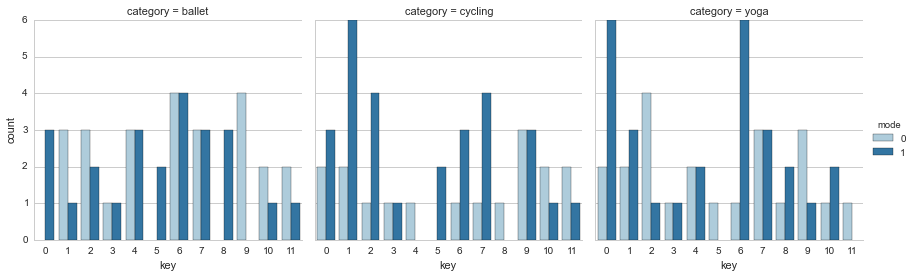

In [9]:
sns.factorplot(x="key", hue="mode", 
               col="category", 
               data=train_df, 
               kind="count", 
               palette='Paired')

The most popular keys per class and their interpretaition, according to [Christian Friedrich Daniel Schubart](http://www.wmich.edu/mus-theo/courses/keys.html), who in the 18th century gave the most poetic description for every key.
* The **ballet class** has more tracks in minor modality. However, this class doesn't have keys that truly stand out. The keys used are: 
    * "F# minor" ("6") is a gloomy key: "it tugs at passion as a dog biting a dress. Resentment and discontent are its languages";
    * "Gb major" ("6") — is compared to a "free sigh of relief utered when hurdles are surmounted", this is a very accurate portrait of my ballet classes;
    * "A minor" ("9") tells about "pious womanliness and tenderness" of music.
    
* The **cycling class** has three leading keys that stand out. All are in major mode:
    * "Db major" ("1") is described as a leering key: "it cannot laugh, but it can smile";
    * "D major" ("2") is the key of "triumph, of Hallelujahs, of war-cries, of victory-rejoicing. Thus, the inviting symphonies, the marches, holiday songs and heaven-rejoicing choruses are set in this key." And the music for cycling!
    * "G major" ("7") key correctly expresses gentle and peaceful emotions of the heart, every tender gratitude for true friendship and faithful love.
    
* The **yoga class** has two prominent keys:
    * "C major" ("0") is completely pure with innocent, naive character like children's talk;
    * "Gb major" ("6") signifies triumph over difficulty, echo of a soul which has fiercely struggled and finally conquered. This is the best description not only of music but of my yoga practices! This key is also one of the leading keys in the ballet class.

#### — Violin plot —
The next step in my visual analysis is to group the data by categories and then look at the basic statistical values for every attribute: mean, median, and standard deviation.  

**Mean** (or average) is just the sum of the data divided by its count. The mean is strongly affected by outliers and is not a robust estimator for central location: the mean is not necessarily a typical example of the data points. For more robust, although less efficient, a measure of central location, **median** is used.
**Standard deviation** is a measure of how spread out numbers are.

I make a violinplot to visualize the data. Violin plot combines a boxplot with the kernel density estimation procedure to provide a better description of the distribution of values. Additionally, the quartile values from the boxplot are shown inside the violin by adding inner="quartile" parameter. Mean values are marked with a white cross. 

I also use the function swarmplot() that positions each scatterplot point on the categorical axis with an algorithm that avoids overlapping points. This gives a better representation of the distribution of values.

Here I plot features "acousticness", "danceability", "energy", "instrumentalness", and "valence". These features  spread out from 0 to 1. Note that due to the shape of the plot the figure might go below 0 and above 1. Seaborn allows to limit the violin range within the range of the observed data (cut=0), but here I leave them as is.  

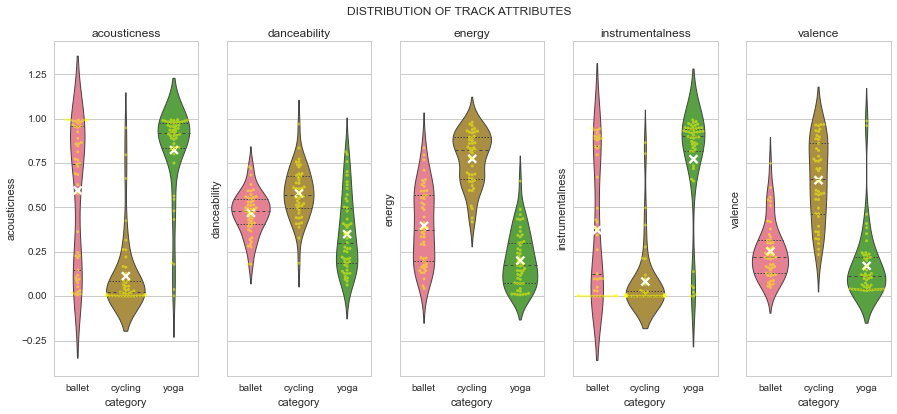

In [10]:
# create 5 subplots
fig1, (ax3, ax4, 
      ax5, ax6, 
      ax7) = plt.subplots(nrows=1, ncols=5,
                          sharey=True, # leave y ticks only on the first column of plots
                          figsize=(15,6))

# add a title
fig1.suptitle('DISTRIBUTION OF TRACK ATTRIBUTES')

# set the step size for yticks
plt.yticks(np.arange(-0.5, 1.5, 0.25))

def violin_plot_attr(df):
    """Create violin plot and swarmplot for
    5 attributes.
    """
    attr = [('acousticness', ax3), 
            ('danceability', ax4),
            ('energy', ax5), 
            ('instrumentalness', ax6), 
            ('valence', ax7)]
    
    for item, ax in attr:
        # add title for a subplot
        ax.set_title(item)
        
        # create a violin plot
        sns.violinplot(x="category", y=item, 
                       data=df, 
                       inner="quartile", # draw the quartiles of the distribution
                       linewidth=1,
                       ax=ax)
        
        # add marker for mean values
        sns.pointplot(x="category", y=item,
                      data=df, 
                      markers="x", 
                      ci=None, # remove confidence intervals 
                      join=False, 
                      color="white", 
                      alpha=.5, # alpha adds saturation
                      ax=ax)
        
        # create a swarmplot on top of the violin plot
        sns.swarmplot(x="category", y=item, 
                      data=df, 
                      alpha=.5, 
                      size=3, 
                      color="yellow", 
                      edgecolor="gray", 
                      ax=ax)
        

violin_plot_attr(train_df)

Looking at the plot I can make the following observations about the data:
* "Violins" of the ballet class in most cases have elongated shape, confirming that points in this class are spread out. 
* Both yoga and cycling classes have long tails on acousticness and instrumentalness plots. Points in the tail are outliers. 
* The cycling and yoga violins on the acousticness subplot are a good example of the effect of outliers on the mean value (white cross). The mean lies quite far from the median value (the middle dashed line) because of outliers in the tail. 
* On acousticness, energy, and instrumentalness subplots the yoga and cycling classes "look" in directly opposite directions showing how different two classes are.  
* The ballet class mean on all subplots lies between the yoga and cycling classes. The level of danceability is almost the same as of the cycling class but the level of energy and valence is much lower. The class has tracks with high and low level of acousticness and instrumentalness.  
* The cycling class can be described as energetic, suitable for dancing though the level of danceability is not very high (the median lies around 0.55 value). The level of valence varies greatly (from 0.2 to 1 with the median around 0.7). At the same time, the level of instrumentalness and acousticness of the class is very low: the median lies around 0 value. 
* The yoga class, on the contrary, has highly acoustic and instrumental music (75% of points lie above 0.8 value). It has low energy and valence (all points lie below 0.5 value). Though several tracks might make someone want to dance, three quartiles of points lie below 0.5 value in danceability. 
#### — Box plot —
Because "loudness" and "tempo" have a different value range, I visualise these features separately. I also don't want to squeeze all features into one plot.  

I use box plot, which is the foundation of the violin plot. A box plot (or box-and-whisker plot) shows the distribution of quantitative data. The box shows the quartiles of the dataset while the whiskers extend to show the rest of the distribution, except for points that are determined to be “outliers” using a method that is a function of the inter-quartile range.

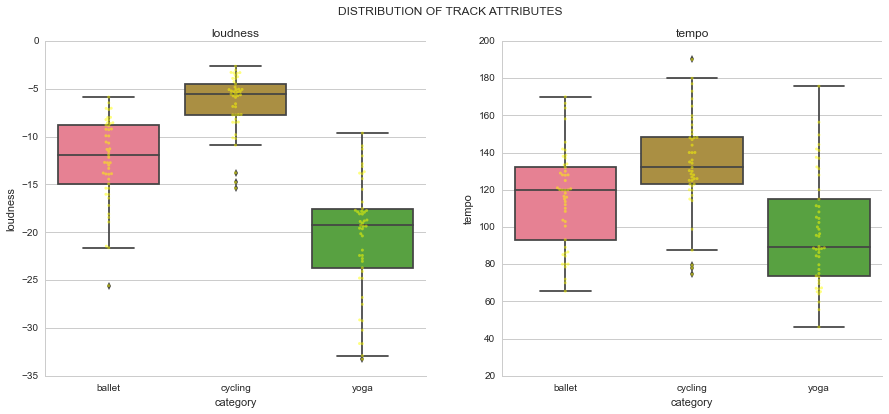

In [11]:
# create 2 subplots
fig2, (ax8, ax9) = plt.subplots(nrows=1, ncols=2,
                              sharey=False,
                              figsize=(15,6))

fig2.suptitle('DISTRIBUTION OF TRACK ATTRIBUTES')

# remove the top and right spines from plots
sns.despine()

def box_plot_attr(df):
    """Create box plot and swarmplot for
    2 attributes.
    """
    attr = [('loudness', ax8), 
            ('tempo', ax9)]
    
    for item, ax in attr:
        # add title for a subplot
        ax.set_title(item)

        # create a box plot
        sns.boxplot(x="category", y=item,
                   data=df,
                    ax=ax)
        
        # create a swarmplot on top of the violin plot
        sns.swarmplot(x="category", y=item, 
                      data=df, 
                      alpha=.5, size=3,
                      color="yellow", edgecolor="gray", 
                      ax=ax)
        
        
box_plot_attr(train_df)

* Points of the ballet class, again, lie between the other two classes. The music is not very loud and has farily high tempo. 
* Tracks of the cycling class are loud and have high level of tempo. 
* The yoga class is not loud and, on average, has low tempo. 

The next step is to calculate the precise values of mean, median, and standard deviation. 

In [12]:
# group by category
grouped = train_df.groupby(['category'])

# make a DF
pd.concat((grouped.mean(), 
           grouped.median(),
           grouped.std()), 
          axis=0, 
          keys=['mean', 'median', 
                'standard deviation'])

acousticness  danceability  energy  \
                   category                                       
mean               ballet            0.60          0.47    0.40   
                   cycling           0.11          0.58    0.77   
                   yoga              0.82          0.35    0.20   
median             ballet            0.75          0.48    0.37   
                   cycling           0.02          0.57    0.82   
                   yoga              0.92          0.30    0.17   
standard deviation ballet            0.39          0.12    0.21   
                   cycling           0.21          0.14    0.15   
                   yoga              0.25          0.21    0.15   

                             instrumentalness  key  loudness  mode  \
                   category                                          
mean               ballet                0.37 5.45    -12.38  0.49   
                   cycling               0.08 4.93     -6.51  0.62   
                   yoga                  0.77 4.63    -20.33  0.55   
median             ballet                0.13 6.00    -11.89  0.00   
                   cycling               0.00 5.00     -5.56  1.00   
                   yoga                  0.90 5.00    -19.26  1.00   
standard deviation ballet                0.39 3.21      4.36  0.51   
                   cycling               0.20 3.75      3.04  0.49   
                   yoga                  0.31 3.43      6.03  0.50   

                             speechiness  tempo  time_signature  valence  
                   category                                               
mean               ballet           0.04 115.43            3.73     0.25  
                   cycling          0.06 134.19            4.00     0.65  
                   yoga             0.06  97.96            3.55     0.17  
median             ballet           0.04 119.78            4.00     0.22  
                   cycling          0.05 132.00            4.00     0.66  
                   yoga             0.04  89.41            4.00     0.11  
standard deviation ballet           0.02  26.04            0.57     0.16  
                   cycling          0.05  25.83            0.00     0.23  
                   yoga             0.11  29.88            0.94     0.20

These values confirm the differences between the three groups, which are also noticeable when observing the above plots.
* The ballet class can be described as acoustic but not very instrumental music, suitable for dancing, with high tempo. It's not energetic and has low valence.
* The cycling class is very energetic, loud, positive, has high level of valence and tempo, is good for dancing while cycling. It's mainly electronic, rather than acoustic and instrumental. 
* The yoga class, just the opposite, has very high level of acousticness and instrumentalness. It won't make someone dance and sounds quite sad (valence is low). 

### Test data overview
Now I move on to the exploration of the test dataset.

In [14]:
print ("There are {} tracks in the test dataframe."
       .format(len(test_df)))
print "\nSummary statistics: "
test_df.describe()

There are 536 tracks in the test dataframe.

Summary statistics: 


,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
count,536.00,536.00,536.00,536.00,536.00,536.00,536.00,536.00,536.00,536.00,536.00
mean,0.31,0.58,0.60,0.30,5.34,-9.94,0.54,0.07,116.66,3.93,0.47
std,0.32,0.18,0.24,0.36,3.59,5.15,0.50,0.07,25.87,0.42,0.26
min,0.00,0.06,0.02,0.00,0.00,-34.53,0.00,0.02,0.00,0.00,0.02
25%,0.03,0.48,0.42,0.00,2.00,-11.89,0.00,0.03,99.96,4.00,0.25
50%,0.19,0.61,0.64,0.06,5.00,-8.83,1.00,0.04,119.01,4.00,0.48
75%,0.56,0.70,0.80,0.66,8.00,-6.35,1.00,0.06,131.26,4.00,0.66
max,0.99,0.95,1.00,0.99,11.00,-1.65,1.00,0.79,201.81,5.00,0.98


These data give us some idea about tracks in the test set, although data points are very spread out.  
On average, music in my library is:
* not very acoustic (50% of tracks are below 0.19 value);
* good for dancing (75% of tracks have the level of danceability higher than 0.48); 
* energetic (mean equals 0.60) and ranges from no energy (0.02) to 100% energy (1);
* mainly electronic (50% of tracks have level of instrumentalness below 0.06);
* loud (the maximum level of loudness is -1.65, almost reaches 0, the maximum possible level);
* speechless but there is an observation with level of speechiness of 0.79;
* not fast (though the feature varies from 0 to 201.81, 50% of tracks have the tempo lower than 119.01 (on the same level as the ballet class).

### Test data visualisation
#### — Count plot —
I use count plot for "key", "mode", and "time_signature" attributes, which are discrete, to show the count of tracks in each bin using bars.

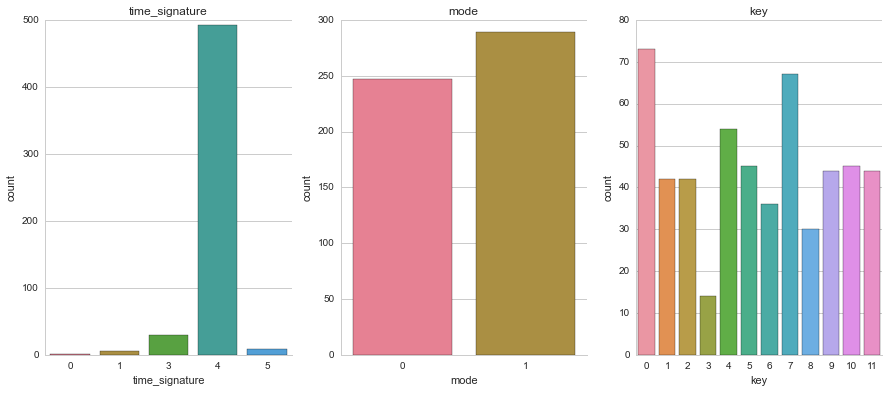

In [16]:
# create 3 subplots
fig4, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3,
                                      sharey=False,
                                      figsize=(15,6))

# remove the top and right spines from plots
sns.despine()

count_plot_attr(df=test_df, hue=None)

Looking at the plot I can make the following observations about the data:
* The most common time signature is 4 beats per measure.
* The test set observations are slightly inclined towards major modality: I favour music that is bright, cheerful, inspiring. 
* All keys are present in the test set. I plot modality and the tonic together. It's preferable to examine these two attributes together. 

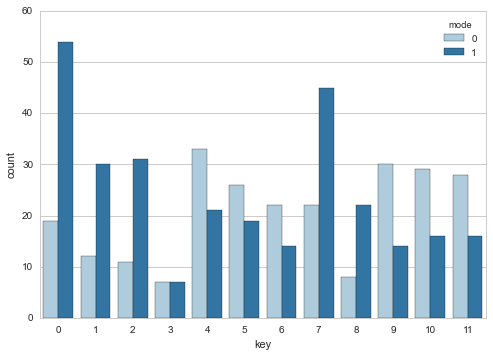

In [17]:
sns.countplot(x='key', hue='mode',
             data=test_df, 
             palette='Paired')

The most popular keys in the test set and their interpretation:
* "C major" ("0") is the most popular key in the test set. It is described by Schubart as completely pure, innocent, naive;
* "G major" ("7") is compared with "gentle and peaceful emotion of the heart";
* "E minor" ("4") stands for "womanly innocent declaration of love; this key speaks of the imminent hope of resolving in the pure happiness of C major";
* "D major" ("2") is the key of "triumph, of Hallelujahs, of war-cries, of victory-rejoicing";
* "A minor" ("9") is associated with tenderness;
* "B-flat minor" ("10") is "dressed in the garment of night... discontented with itself and with everything; preparation for suicide sounds in this key."

It seems, my music library has options for every occasion and taste. 

#### — Scatterplot —
Next, I use pairplot to create a matrix of scatterplots to see the relationships between features in the dataset. 

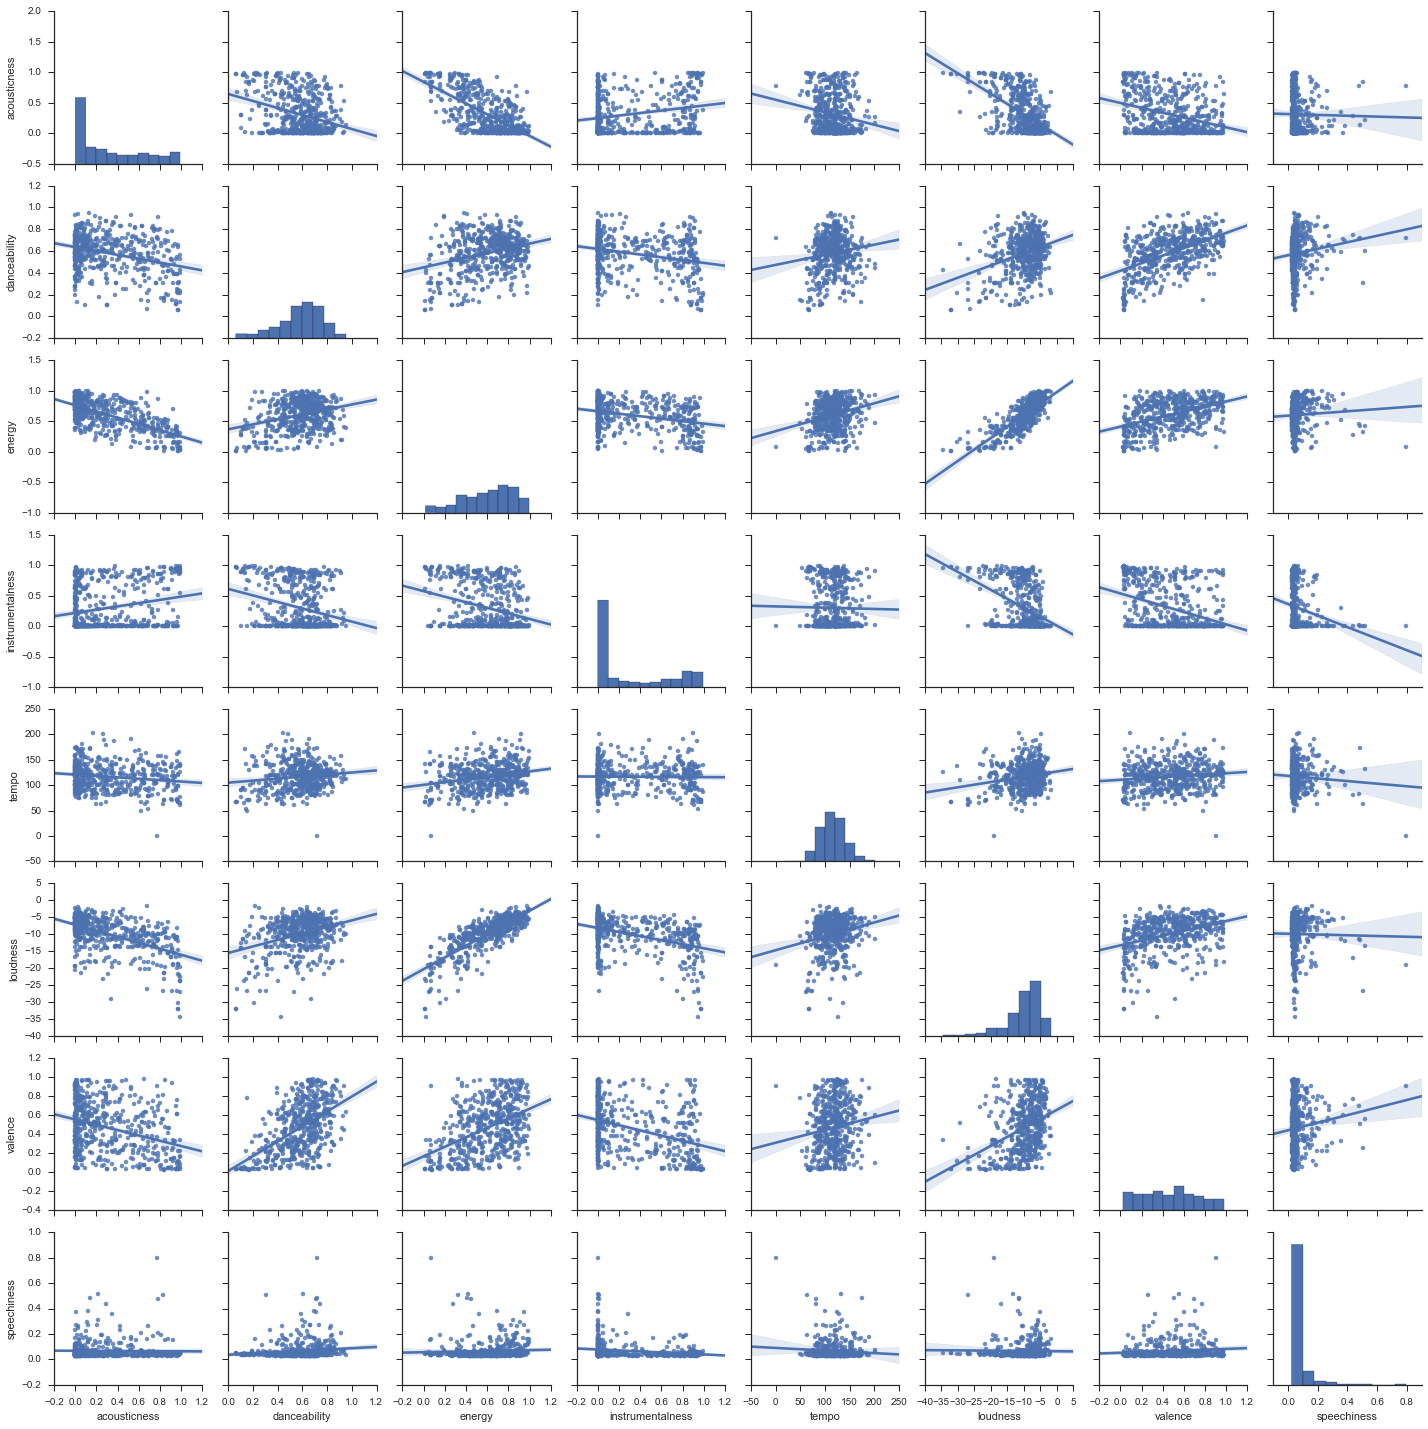

In [19]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(test_df, 
             vars=['acousticness', 'danceability', 
                   'energy', 'instrumentalness', 
                   'tempo', 'loudness','valence',
                  'speechiness'],
            kind="reg")

* Acousticness and instrumentalness have similar data distribution. Many observations in the test set have the level of acousticness and instrumentalness equal to 0. 
* Acousticness and energy seem to be negatively correlated: the higher the level of acousticness, the lower the  energy.
* Danceability is positively correlated with valence.
* Loudness is correlated with energy: both rise together.

#### — Correlation matrix —
To confirm my observations about the correlation of some features, I calculate correlation and make a correlation matrix. 

In [20]:
# compute a correlation matrix
corrmat = test_df.corr()

print "Correlation matrix, values"
corrmat

Correlation matrix, values


,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
acousticness,1.00,-0.32,-0.67,0.23,-0.05,-0.55,-0.00,-0.02,-0.17,-0.14,-0.33
danceability,-0.32,1.00,0.30,-0.26,0.08,0.33,-0.05,0.12,0.14,0.18,0.52
energy,-0.67,0.30,1.00,-0.30,0.06,0.80,0.02,0.05,0.25,0.18,0.45
instrumentalness,0.23,-0.26,-0.30,1.00,-0.08,-0.42,0.02,-0.19,-0.02,-0.05,-0.37
key,-0.05,0.08,0.06,-0.08,1.00,0.13,-0.22,0.03,0.13,0.02,0.06
loudness,-0.55,0.33,0.80,-0.42,0.13,1.00,0.00,-0.02,0.21,0.13,0.37
mode,-0.00,-0.05,0.02,0.02,-0.22,0.00,1.00,0.01,-0.11,-0.07,0.03
speechiness,-0.02,0.12,0.05,-0.19,0.03,-0.02,0.01,1.00,-0.07,-0.18,0.11
tempo,-0.17,0.14,0.25,-0.02,0.13,0.21,-0.11,-0.07,1.00,0.04,0.13
time_signature,-0.14,0.18,0.18,-0.05,0.02,0.13,-0.07,-0.18,0.04,1.00,0.10


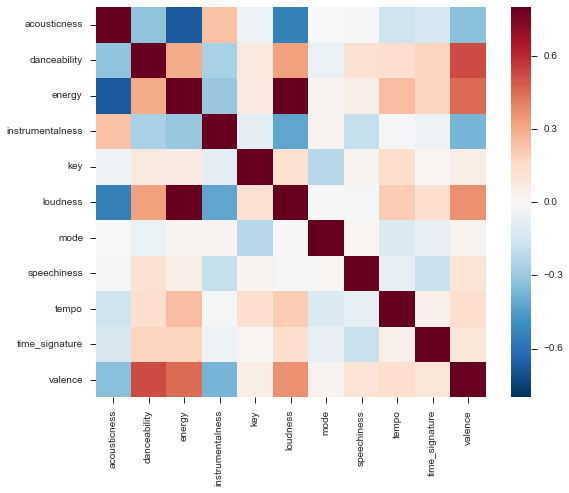

In [21]:
# set up the matplotlib figure
fig3, ax = plt.subplots(figsize=(9, 7))

# draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)

* Indeed, acousticness is negatively correlated with energy (-0.67) and even with loudness (-0.55).
* Energy and loudness are strongly correlated (0.80).
* Valence is slightly correlated with danceability (0.52).

## Summary
In this notebook, I used different plots to examine the data I'm going to work with in the following posts. 
The observations I made about **the training set**:
* Datapoints from the cycling and yoga classes tend to form distinct clusters, whereas the ballet class is very spread out and lies mainly in-between the other two classes.  

**The ballet class**:
* The class can be described as acoustic but not very instrumental music, with high tempo, suitable for dancing. 
* It's not energetic, has low valence, not loud and has quite high tempo. 
* The class has more tracks in minor modality. The overall mood is gentle and tender, sometimes sad and gloomy, and is compared to a "free sigh of relief utered when hurdles are surmounted".

**The cycling class**:
* Tracks of that class are energetic, loud, positive, suitable for dancing (probably while cycling), and have high tempo. 
* It's mainly electronic, rather than acoustic and instrumental.  
* The class has more tracks in major modality. The overall mood of the class is triumphant and happy, tender, sometimes even leering. 

**The yoga class**:
* Tracks of that class, just the opposite, have very high level of acousticness and instrumentalness. 
* This music won't make someone dance, sounds quite sad (valence is low) and has low energy and tempo levels.
* The class has more tracks in major modality. The overall mood of the class is innocent, naive, feels like a triumph over difficulty, echo of a soul which has fiercely struggled and finally conquered. This is the best description not only for music but for my yoga practices!
    
The observations I made about **the test set**:
* The set seems to have options for every occasion and mood: from victory-rejoicing and triumph to preparation for suicide.
* Observations are slightly inclined towards major modality. This is good news: I favour music that is bright, cheerful, inspiring.
* On average, music in my library is not very acoustic, mainly electronic, energetic, loud, good for dancing. 

We'll see how many tracks from the test set would match the training set. But first, I need to preprocess data to use it as input for Scikit-learn machine learning algorithms. This is the goal of the next post [03_Preprocessing](https://github.com/Tykovka/itunes-music-analysis/blob/master/03_Preprocessing.ipynb). 